In [594]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import mannwhitneyu, ks_2samp, kstest, norm, spearmanr, kendalltau, jarque_bera
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [525]:
df = pd.read_csv('Medicaldataset.csv')

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [529]:
df.head()

Age  Gender  Heart rate  Systolic blood pressure  Diastolic blood pressure  \
0   64       1          66                      160                        83   
1   21       1          94                       98                        46   
2   55       1          64                      160                        77   
3   64       1          70                      120                        55   
4   55       1          64                      112                        65   

   Blood sugar  CK-MB  Troponin    Result  
0        160.0   1.80     0.012  negative  
1        296.0   6.75     1.060  positive  
2        270.0   1.99     0.003  negative  
3        270.0  13.87     0.122  positive  
4        300.0   1.08     0.003  negative

In [642]:
df

array([160,  98, 120, 112, 179, 214, 154, 166, 150, 199, 122, 118, 114,
       100, 107, 109, 151, 110, 104, 106, 152, 134, 135, 131, 137, 121,
       145, 136, 156, 155, 105,  91, 101, 111, 115, 133, 153, 125, 130,
       127, 140, 128, 123,  94,  95, 117, 124, 119, 138, 157, 202, 175,
       144, 129,  97, 116, 113, 148, 164, 192, 171, 108, 132,  85,  89,
        87,  99,  96,  86,  70,  71,  78, 126, 170, 169, 149, 168, 141,
       191, 193, 167, 165, 146,  93, 180,  42, 220, 147, 142, 102, 103,
       143, 139, 178,  80,  84,  83,  65, 208,  76,  90,  92, 183,  88,
       158, 161, 176, 159, 198, 204, 200, 162, 177, 223,  67, 209],
      dtype=int64)

In [531]:
df['Result'].value_counts()

Result
positive    810
negative    509
Name: count, dtype: int64

In [533]:
df.describe()

Age       Gender   Heart rate  Systolic blood pressure  \
count  1319.000000  1319.000000  1319.000000              1319.000000   
mean     56.191812     0.659591    78.336619               127.170584   
std      13.647315     0.474027    51.630270                26.122720   
min      14.000000     0.000000    20.000000                42.000000   
25%      47.000000     0.000000    64.000000               110.000000   
50%      58.000000     1.000000    74.000000               124.000000   
75%      65.000000     1.000000    85.000000               143.000000   
max     103.000000     1.000000  1111.000000               223.000000   

       Diastolic blood pressure  Blood sugar        CK-MB     Troponin  
count               1319.000000  1319.000000  1319.000000  1319.000000  
mean                  72.269143   146.634344    15.274306     0.360942  
std                   14.033924    74.923045    46.327083     1.154568  
min                   38.000000    35.000000     0.321000     0.001000  
25%                   62.000000    98.000000     1.655000     0.006000  
50%                   72.000000   116.000000     2.850000     0.014000  
75%                   81.000000   169.500000     5.805000     0.085500  
max                  154.000000   541.000000   300.000000    10.300000

In [535]:
# Remove unreal/extremely skewed samples
df = df[df['Heart rate']<1000]

In [537]:
numeric_vars = ['Age', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']

## Descriptive statistics ##

In [539]:
summary_table = pd.DataFrame({
    'Mean': df[numeric_vars].mean(),
    'Median': df[numeric_vars].median(),
    'Variance': df[numeric_vars].var(),
    'Kurtosis': df[numeric_vars].kurt(),
    'Skewness': df[numeric_vars].skew()
})

# Round for presentation
summary_table = summary_table.round(2)

# Display the table
print(summary_table)

# Optional: save to CSV for inserting in LaTeX or Word
#summary_table.to_csv("summary_statistics_tle.csv")
#summary_table.to_excel("summary_statistics_table.xlsx", engine='openpyxl')

                            Mean  Median  Variance  Kurtosis  Skewness
Age                        56.21   58.00    185.99     -0.02     -0.24
Heart rate                 75.98   74.00    233.38      1.18      0.76
Systolic blood pressure   127.14  124.00    683.52      0.95      0.69
Diastolic blood pressure   72.22   72.00    196.22      0.89      0.49
Blood sugar               146.72  116.00   5621.95      4.11      1.93
CK-MB                      15.30    2.85   2150.73     25.42      4.97
Troponin                    0.36    0.01      1.34     39.95      5.80


## Distributions of numerical variables ##

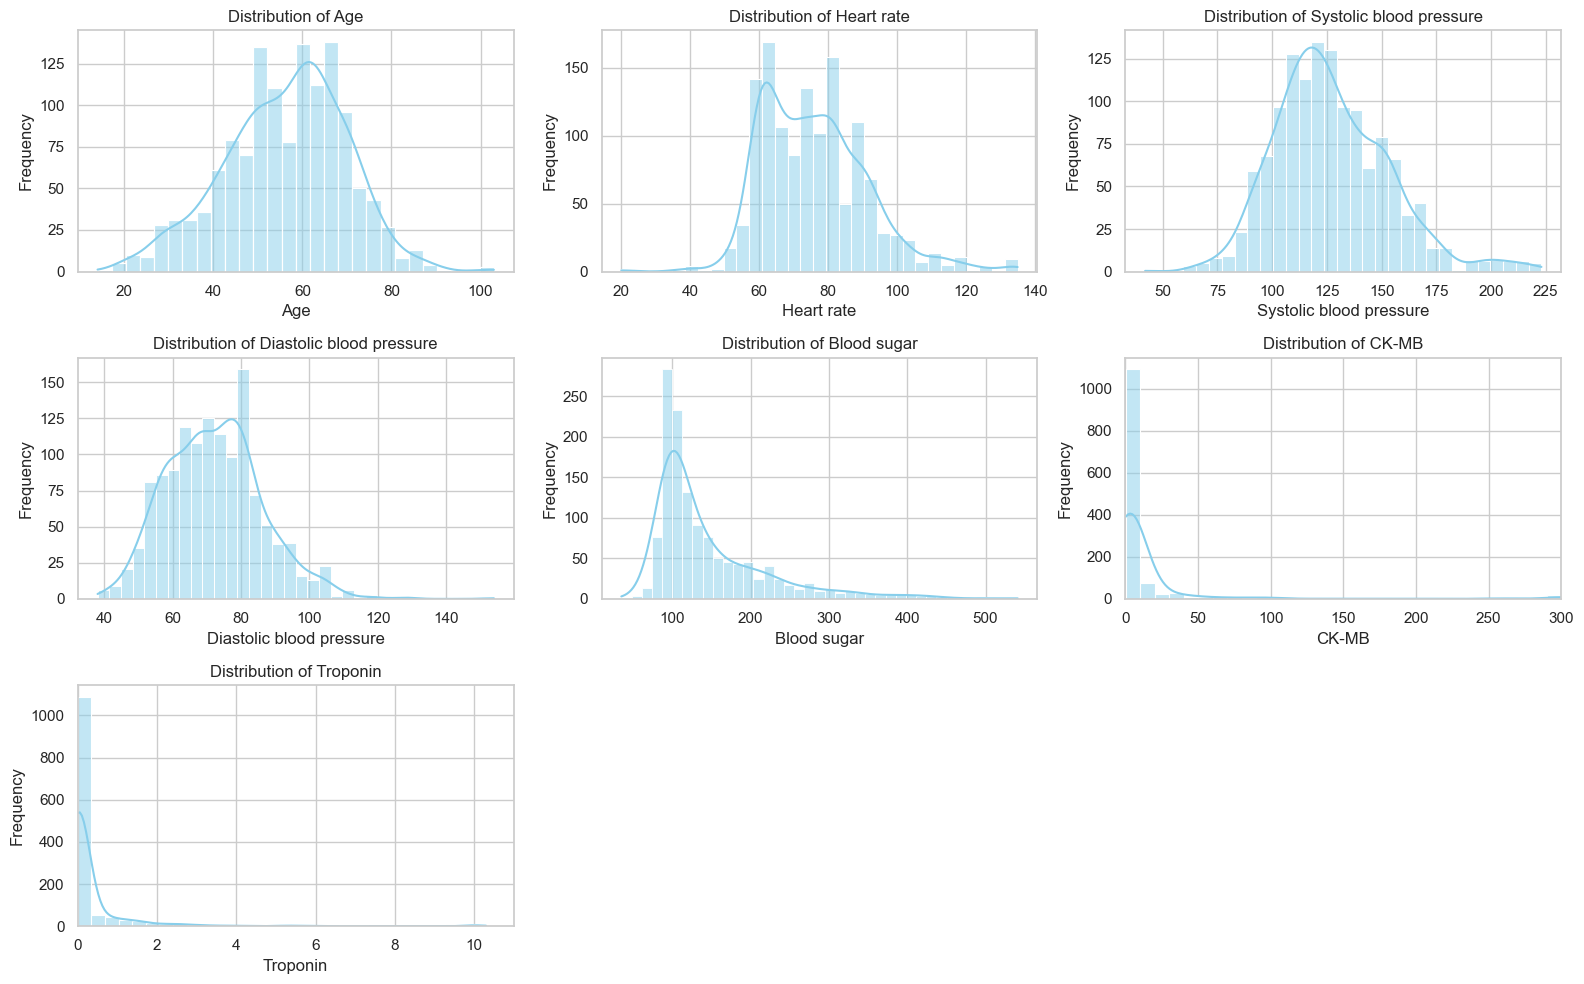

In [541]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_vars[0:5]):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Plot CK-MB
sns.histplot(df['CK-MB'], kde=True, ax=axes[5], bins=30, color='skyblue')
axes[5].set_xlim(0, 300)
axes[5].set_title('Distribution of CK-MB')
axes[5].set_xlabel('CK-MB')
axes[5].set_ylabel('Frequency')

# Plot Troponin
sns.histplot(df['Troponin'], kde=True, ax=axes[6], bins=30, color='skyblue')
axes[6].set_xlim(0, 11)
axes[6].set_title('Distribution of Troponin')
axes[6].set_xlabel('Troponin')
axes[6].set_ylabel('Frequency')

# Remove unused axes
for j in range(7, len(axes)):
    fig.delaxes(axes[j])

# Save and show
plt.tight_layout()
plt.savefig("medical_histograms_all_variables.png")
plt.show()

C:\Users\g1kss\AppData\Local\Temp\ipykernel_15684\1355392303.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result', y='CK-MB', data=df, ax=axes[0], palette='pastel', showfliers=True)
C:\Users\g1kss\AppData\Local\Temp\ipykernel_15684\1355392303.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Result', y='Troponin', data=df, ax=axes[1], palette='pastel', showfliers=True)


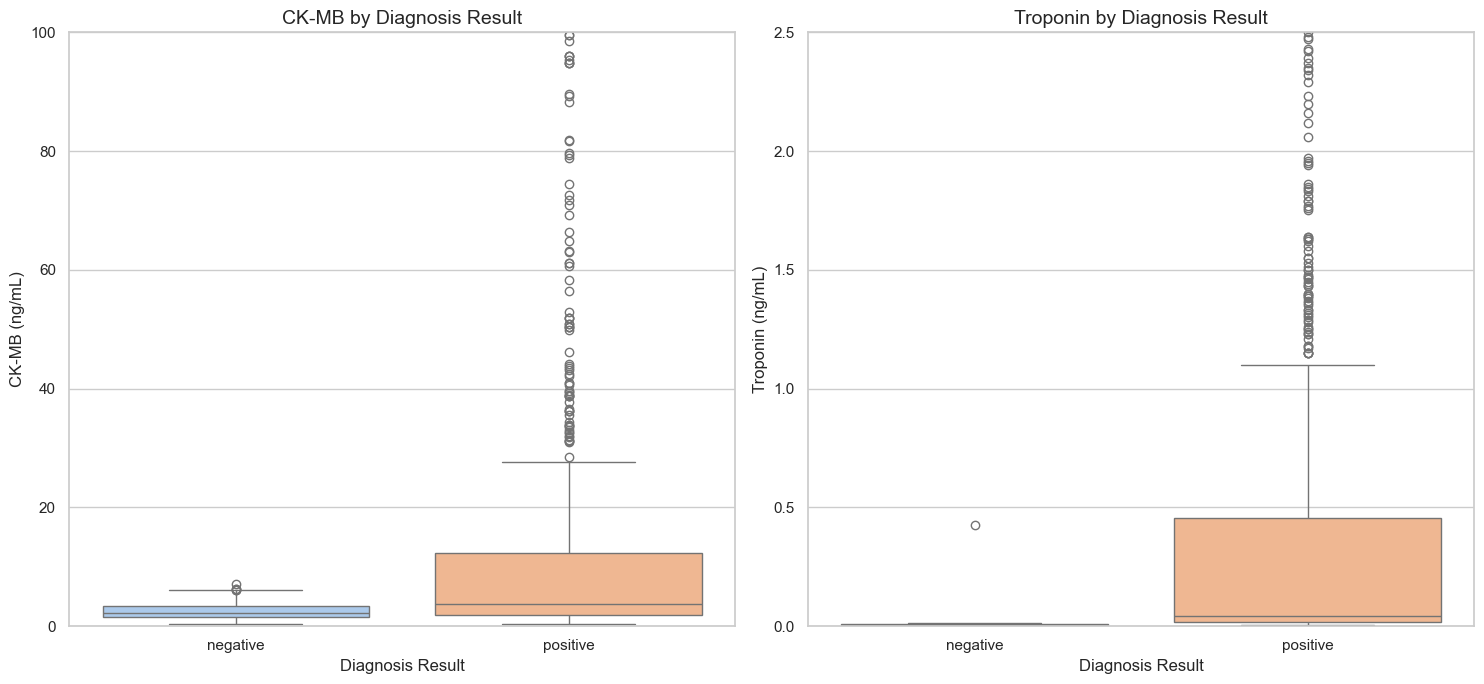

In [543]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# CK-MB with outliers shown
sns.boxplot(x='Result', y='CK-MB', data=df, ax=axes[0], palette='pastel', showfliers=True)
axes[0].set_title('CK-MB by Diagnosis Result', fontsize=14)
axes[0].set_xlabel('Diagnosis Result')
axes[0].set_ylabel('CK-MB (ng/mL)')
axes[0].set_ylim(0, 100)  # Increase y-limit to accommodate visible outliers

# Troponin with outliers shown
sns.boxplot(x='Result', y='Troponin', data=df, ax=axes[1], palette='pastel', showfliers=True)
axes[1].set_title('Troponin by Diagnosis Result', fontsize=14)
axes[1].set_xlabel('Diagnosis Result')
axes[1].set_ylabel('Troponin (ng/mL)')
axes[1].set_ylim(0, 2.5)  # Increase y-limit for visibility

plt.tight_layout()
plt.savefig("boxplots_ckmb_troponin_by_result.png")
plt.show()

In [596]:
group0 = df[df['Result'] == 0] # negative
group1 = df[df['Result'] == 1] # positive 

In [608]:
group0[['CK-MB', 'Troponin']].describe()

CK-MB    Troponin
count  508.000000  508.000000
mean     2.555138    0.027026
std      1.368889    0.443756
min      0.321000    0.001000
25%      1.500000    0.003000
50%      2.295000    0.006000
75%      3.352500    0.009000
max      7.020000   10.000000

In [612]:
group1[['CK-MB', 'Troponin']].describe()

CK-MB    Troponin
count  808.000000  808.000000
mean    23.317994    0.570926
std     57.765013    1.392209
min      0.353000    0.003000
25%      1.870000    0.016000
50%      3.775000    0.044000
75%     12.270000    0.454750
max    300.000000   10.300000

In [545]:
# Encode target for simplification
df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

In [547]:
# We assume the samples are independent from each other
# We take the continuous and ordinal variables 
for var in numeric_vars:
    x_negative = group0[var]
    y_positive = group1[var]
    
    mw = mannwhitneyu(x_negative, y_positive, alternative='less')  # We expect median of CK-MB, Troponin and Heart rate in positive cases 
                                                                        # to be greater than in negative cases
    ks = ks_2samp(x_negative, y_positive) # difference in distributions
    
    print(f"\n=== {var} ===")
    print(f"Mann–Whitney U: statistic = {mw.statistic:.2f}, p-value = {mw.pvalue:.4e}")
    print(f"Kolmogorov–Smirnov: statistic = {ks.statistic:.2f}, p-value = {ks.pvalue:.4e}")


=== Age ===
Mann–Whitney U: statistic = 148215.00, p-value = 9.4307e-18
Kolmogorov–Smirnov: statistic = 0.21, p-value = 7.5622e-13

=== Heart rate ===
Mann–Whitney U: statistic = 205045.50, p-value = 4.8894e-01
Kolmogorov–Smirnov: statistic = 0.03, p-value = 9.0718e-01

=== Systolic blood pressure ===
Mann–Whitney U: statistic = 214167.00, p-value = 9.0849e-01
Kolmogorov–Smirnov: statistic = 0.06, p-value = 2.5054e-01

=== Diastolic blood pressure ===
Mann–Whitney U: statistic = 207245.50, p-value = 6.1798e-01
Kolmogorov–Smirnov: statistic = 0.05, p-value = 4.2959e-01

=== Blood sugar ===
Mann–Whitney U: statistic = 210007.00, p-value = 7.6163e-01
Kolmogorov–Smirnov: statistic = 0.05, p-value = 5.1450e-01

=== CK-MB ===
Mann–Whitney U: statistic = 131000.00, p-value = 9.8170e-29
Kolmogorov–Smirnov: statistic = 0.38, p-value = 6.9719e-41

=== Troponin ===
Mann–Whitney U: statistic = 43809.00, p-value = 1.4554e-128
Kolmogorov–Smirnov: statistic = 0.79, p-value = 8.0466e-196


There is extremely strong evidence that CK-MB levels in negatively diagnosed patients are significantly lower than in positively diagnosed patients 
This aligns with medical expectations — CK-MB is elevated in cardiac damage.

There is overwhelming evidence that Troponin levels in Group 0 are significantly lower than in Group 1.
Troponin is a well-known marker of heart injury and is expected to be elevated in positive cases.

There is no evidence that heart rate is lower in Group 0 compared to Group 1.
The distributions of heart rate are statistically the same between groups under the 'less' hypothesis.
Therefore, heart rate does not help discriminate between the two diagnosis groups.

## Spearman's rho and Kendall’s tau ##

In [549]:
# === Test 1: CK-MB and Troponin ===
x1 = df['CK-MB']
y1 = df['Troponin']

rho_stat1, rho_p1 = spearmanr(x1, y1)
tau_stat1, tau_p1 = kendalltau(x1, y1)

print("=== CK-MB vs Troponin ===")
print("Spearman’s rho: %.4f (p = %.5e)" % (rho_stat1, rho_p1))
print("Kendall’s tau: %.4f (p = %.5e)" % (tau_stat1, tau_p1))

# === Test 2: Diastolic vs Systolic BP ===
x2 = df['Diastolic blood pressure']
y2 = df['Systolic blood pressure']

rho_stat2, rho_p2 = spearmanr(x2, y2)
tau_stat2, tau_p2 = kendalltau(x2, y2)

print("\n=== Diastolic vs Systolic Blood Pressure ===")
print("Spearman’s rho: %.4f (p = %.5e)" % (rho_stat2, rho_p2))
print("Kendall’s tau: %.4f (p = %.5e)" % (tau_stat2, tau_p2))

# === Test 3: Age vs Troponin ===
x2 = df['Age']
y2 = df['Troponin']

rho_stat2, rho_p2 = spearmanr(x2, y2)
tau_stat2, tau_p2 = kendalltau(x2, y2)

print("\n=== Age vs Troponin ===")
print("Spearman’s rho: %.4f (p = %.5e)" % (rho_stat2, rho_p2))
print("Kendall’s tau: %.4f (p = %.5e)" % (tau_stat2, tau_p2))

=== CK-MB vs Troponin ===
Spearman’s rho: -0.0474 (p = 8.53238e-02)
Kendall’s tau: -0.0323 (p = 8.45990e-02)

=== Diastolic vs Systolic Blood Pressure ===
Spearman’s rho: 0.6052 (p = 2.56096e-132)
Kendall’s tau: 0.4549 (p = 5.03477e-130)

=== Age vs Troponin ===
Spearman’s rho: 0.3657 (p = 6.38294e-43)
Kendall’s tau: 0.2499 (p = 1.16765e-39)


CK-MB and Troponin

Both Spearman’s and Kendall’s nonparametric correlation tests were applied to assess the monotonic association between CK-MB and Troponin. The results showed very weak negative correlations (Spearman’s ρ = –0.05, Kendall’s τ = –0.03), with p-values of 0.085 and 0.084 respectively. These values are above the standard 0.05 significance level, indicating no statistically significant monotonic relationship between the two cardiac biomarkers in this sample.

Diastolic and Systolic Blood Pressure

To evaluate the relationship between diastolic and systolic blood pressure, both Spearman’s and Kendall’s tests revealed strong positive correlations. Spearman’s ρ was 0.61 and Kendall’s τ was 0.46, with both p-values far below 0.001 (2.56×10⁻¹³² and 5.03×10⁻¹³⁰, respectively). These findings confirm a highly significant monotonic association, consistent with known physiological interactions between the two blood pressure measures.

Age and Troponin

A moderate positive monotonic relationship was observed between age and Troponin levels. Spearman’s ρ was 0.37 and Kendall’s τ was 0.25, with highly significant p-values (6.38×10⁻⁴³ and 1.17×10⁻³⁹, respectively). This indicates that older patients tend to have higher Troponin levels, potentially reflecting age-related cardiovascular vulnerability.

## Spearman, Pearson and Kendall Correlation Matrices ##

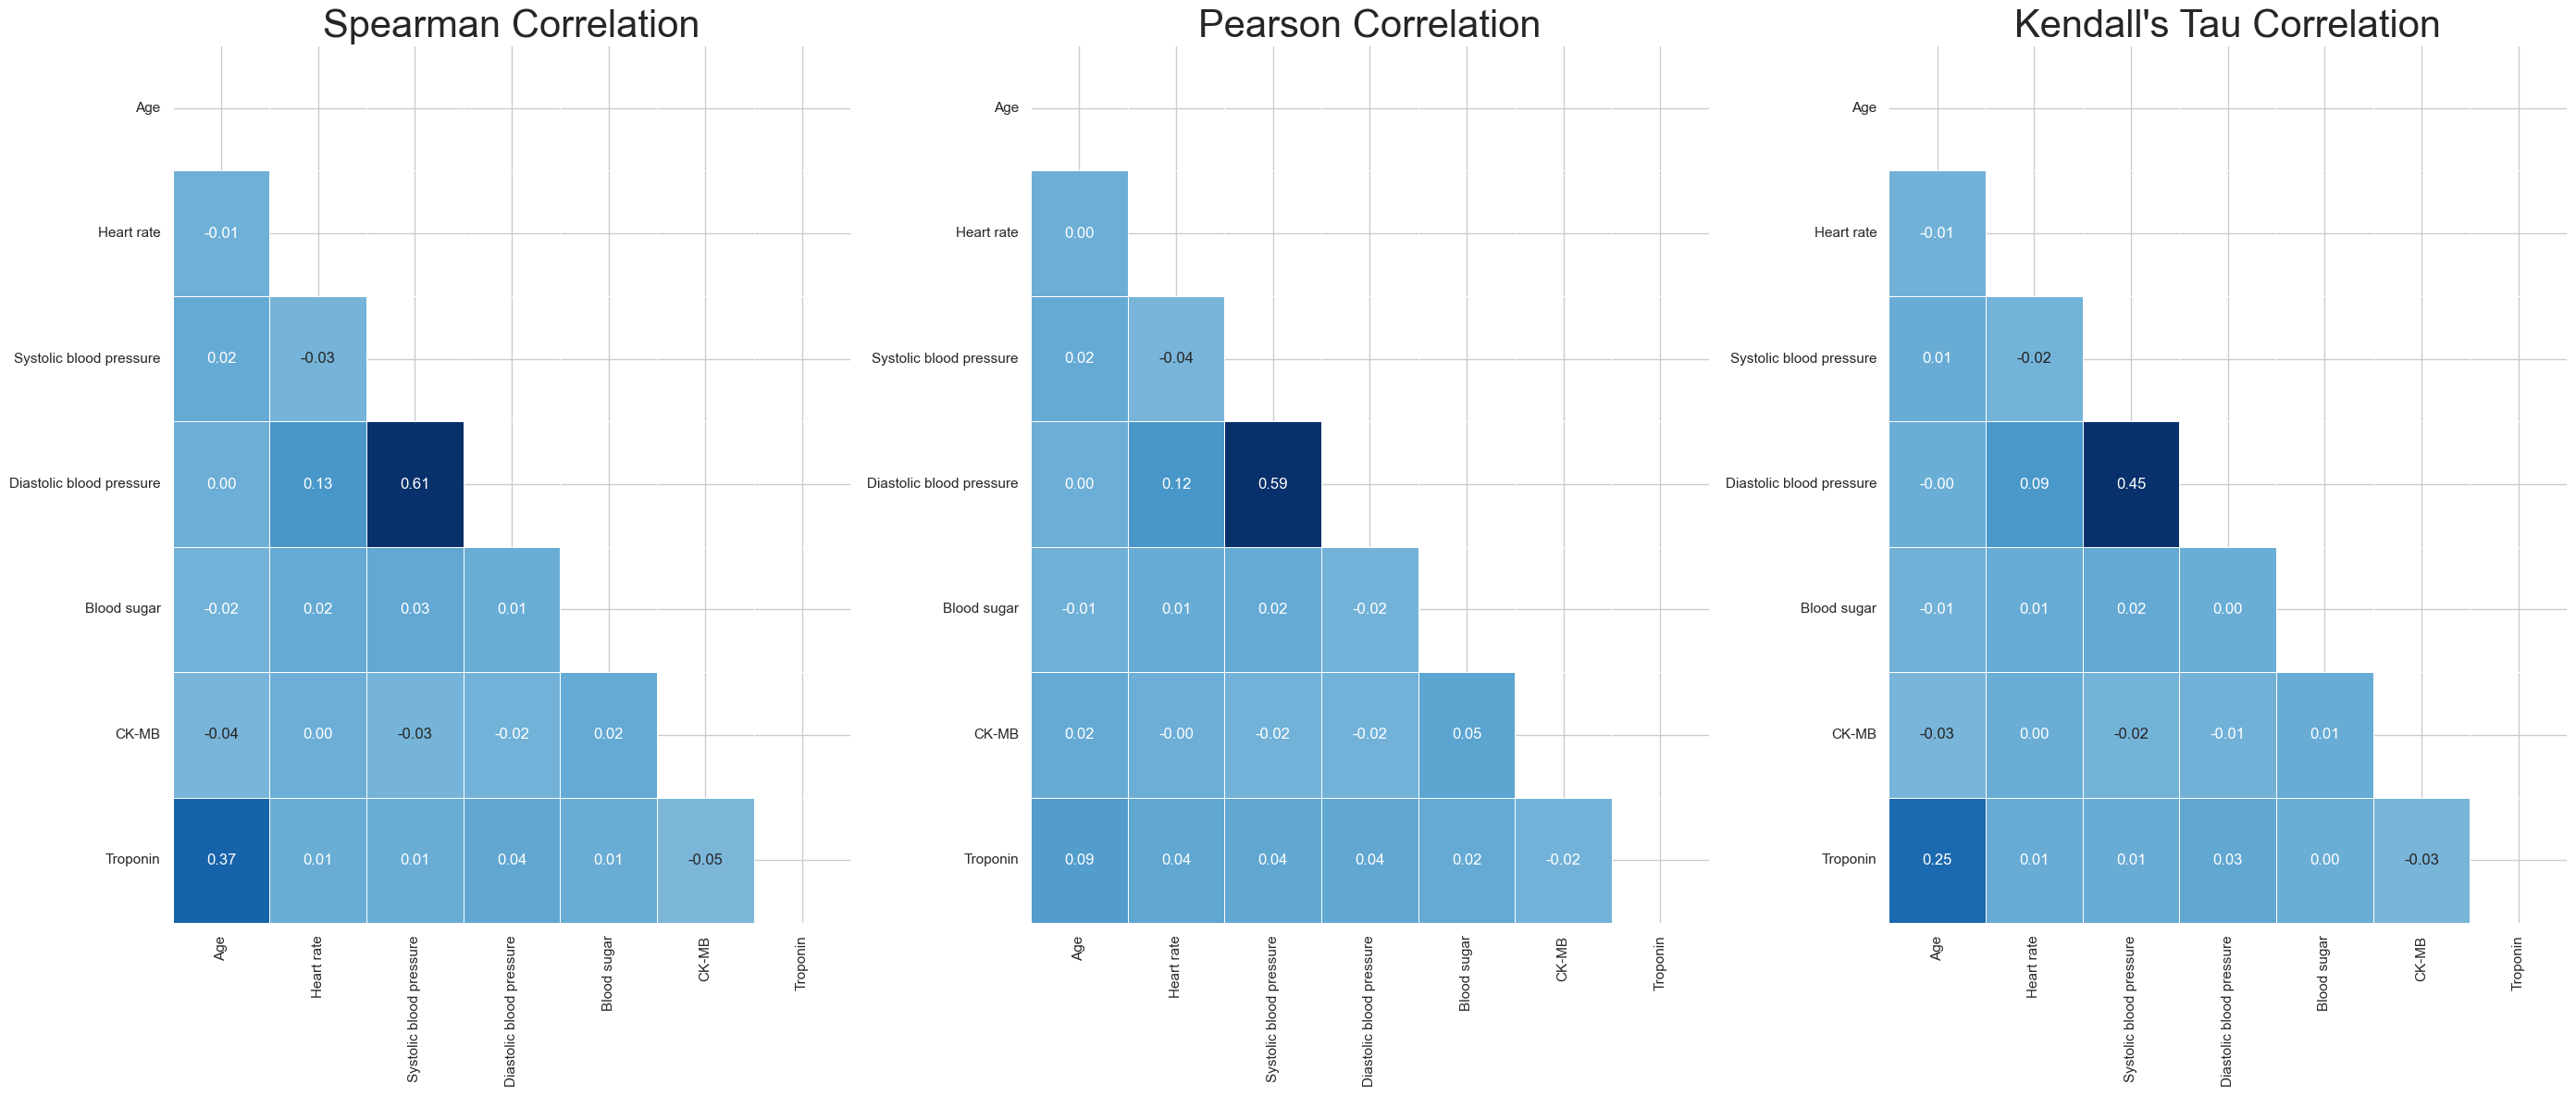

In [638]:
# Calculate Spearman, Pearson and Kendall correlation matrices to ensure accuracy
spearman_correlation = df[numeric_vars].corr(method='spearman').round(2)
pearson_correlation = df[numeric_vars].corr(method='pearson').round(2)
kendall_correlation = df[numeric_vars].corr(method='kendall').round(2)

# Create a single figure with three subplots for side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(28, 12))

# Mask upper triangle to eliminate redundant values
mask = np.triu(np.ones_like(pearson_correlation, dtype=bool))

# Spearman
sns.heatmap(spearman_correlation, annot=True, cmap='Blues', mask=mask, ax=axes[0], center=0, linewidths=0.5, fmt=".2f", cbar=False)
axes[0].set_title("Spearman Correlation", fontsize=30)

# Pearson
sns.heatmap(pearson_correlation, annot=True, cmap='Blues', mask=mask, ax=axes[1], center=0, linewidths=0.5, fmt=".2f", cbar=False)
axes[1].set_title("Pearson Correlation", fontsize=30)

# Kendall
sns.heatmap(kendall_correlation, annot=True, cmap='Blues', mask=mask, ax=axes[2], center=0, linewidths=0.5, fmt=".2f", cbar=False)
axes[2].set_title("Kendall's Tau Correlation", fontsize=30)

plt.tight_layout()
fig.savefig("comparison_correlation_matrices_corrected.png")

## Scatterplots for CK-MB vs Troponin / Diastolic vs Systolic BP / Age vs Troponin ##

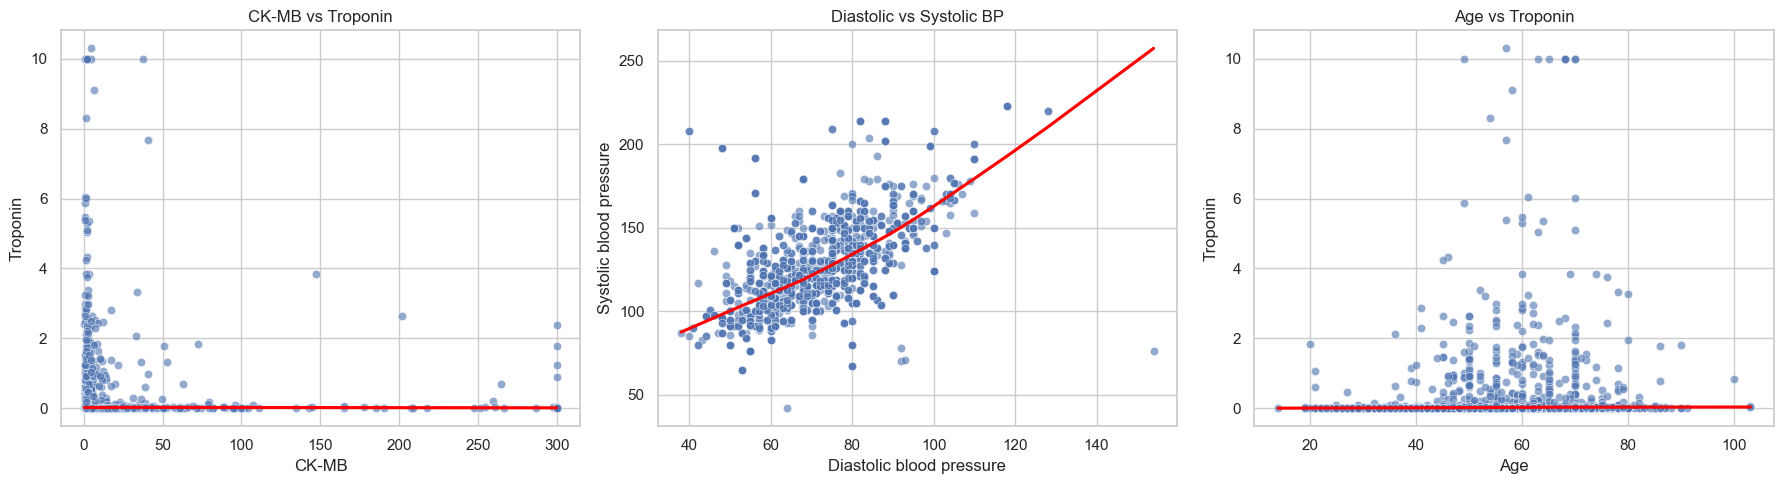

In [553]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: CK-MB vs Troponin
sns.scatterplot(x='CK-MB', y='Troponin', data=df, ax=axes[0], alpha=0.6)
sns.regplot(x='CK-MB', y='Troponin', data=df, ax=axes[0], lowess=True, scatter=False, color='red')
axes[0].set_title('CK-MB vs Troponin')

# Plot 2: Diastolic vs Systolic BP
sns.scatterplot(x='Diastolic blood pressure', y='Systolic blood pressure', data=df, ax=axes[1], alpha=0.6)
sns.regplot(x='Diastolic blood pressure', y='Systolic blood pressure', data=df, ax=axes[1], lowess=True, scatter=False, color='red')
axes[1].set_title('Diastolic vs Systolic BP')

# Plot 3: Age vs Troponin
sns.scatterplot(x='Age', y='Troponin', data=df, ax=axes[2], alpha=0.6)
sns.regplot(x='Age', y='Troponin', data=df, ax=axes[2], lowess=True, scatter=False, color='red')
axes[2].set_title('Age vs Troponin')

plt.tight_layout()
fig.savefig("association_scatterplots.png")

## Kolmogorov Smirnov test for normality and ECDF and Normal CDF comparison ##

In [555]:
# Kolmogorov-Smirnov test for normality
print('KS test for normality')
for var in numeric_vars:
    x = df[var]
    x_norm = (x - x.mean()) / x.std()
    ks_stat, ks_p = kstest(x_norm, 'norm')
    print(f"({var}): stat=%.4f, p=%.4e" % (ks_stat, ks_p))   # we have ties in age, heart rate, but good ranging

KS test for normality
(Age): stat=0.0799, p=9.4715e-08
(Heart rate): stat=0.0732, p=1.3955e-06
(Systolic blood pressure): stat=0.0795, p=1.0936e-07
(Diastolic blood pressure): stat=0.0403, p=2.6819e-02
(Blood sugar): stat=0.1853, p=5.2368e-40
(CK-MB): stat=0.3762, p=7.8463e-168
(Troponin): stat=0.3777, p=3.3694e-169


The one-sample Kolmogorov–Smirnov test was conducted to evaluate whether the continuous variables in the dataset followed a normal distribution. Results showed that none of the variables met the assumption of normality (p < 0.05). While Age, Heart Rate, and Blood Pressure exhibited moderate departures from normality, variables such as Blood Sugar, CK-MB, and Troponin were highly skewed. These results justify the consistent use of nonparametric statistical techniques in the analysis, including Mann–Whitney U tests, Spearman’s and Kendall’s correlations, and nonparametric regression.

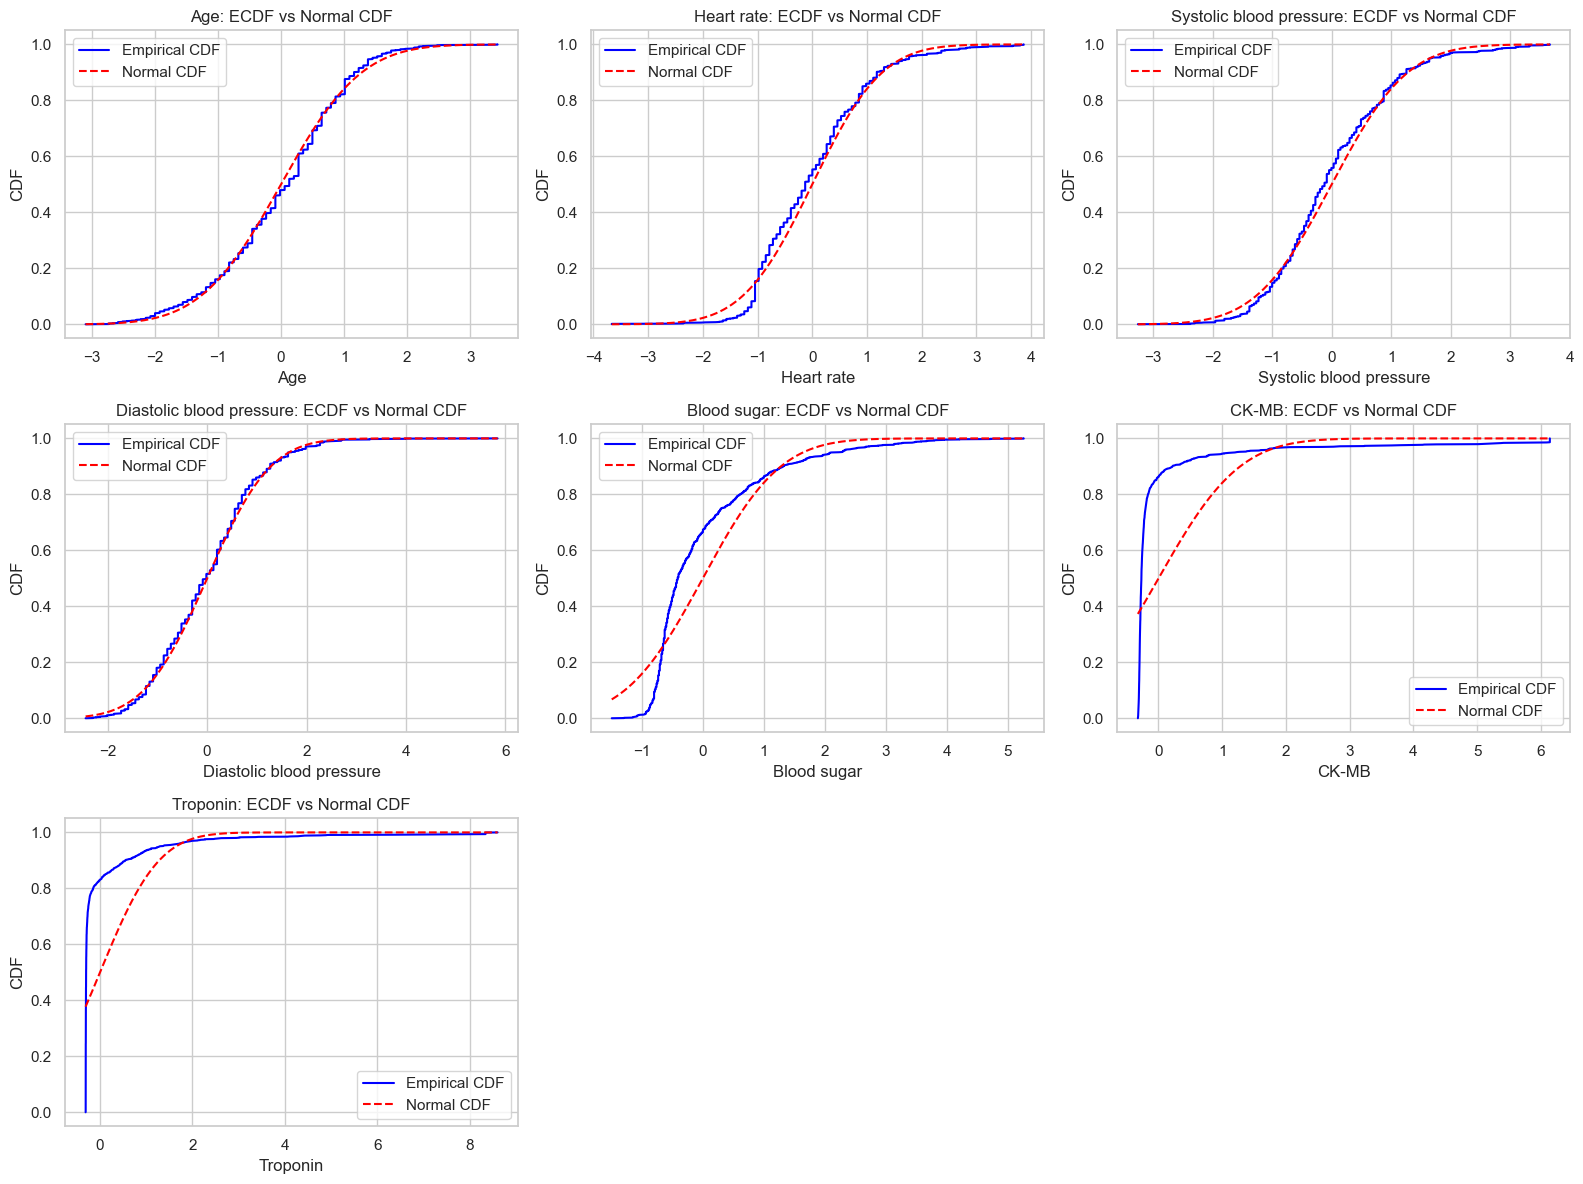

In [557]:
# Empirical CDF vs Normal CDF
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    data = df[var]
    ecdf = ECDF(data)

    # Standardize data for comparison to standard normal
    data_std = (data - np.mean(data)) / np.std(data)
    ecdf_std = ECDF(data_std)

    # Generate x-values for theoretical normal CDF
    x = np.linspace(min(data_std), max(data_std), 1000)
    y = norm.cdf(x)

    # Plot ECDF and normal CDF
    axes[i].plot(ecdf_std.x, ecdf_std.y, label='Empirical CDF', color='blue')
    axes[i].plot(x, y, label='Normal CDF', color='red', linestyle='--')
    axes[i].set_title(f'{var}: ECDF vs Normal CDF')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('CDF')
    axes[i].legend()

# Remove any unused subplots
for j in range(len(numeric_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("ecdf_vs_normal_all.png")

## QQ-plot for continuous variables ##

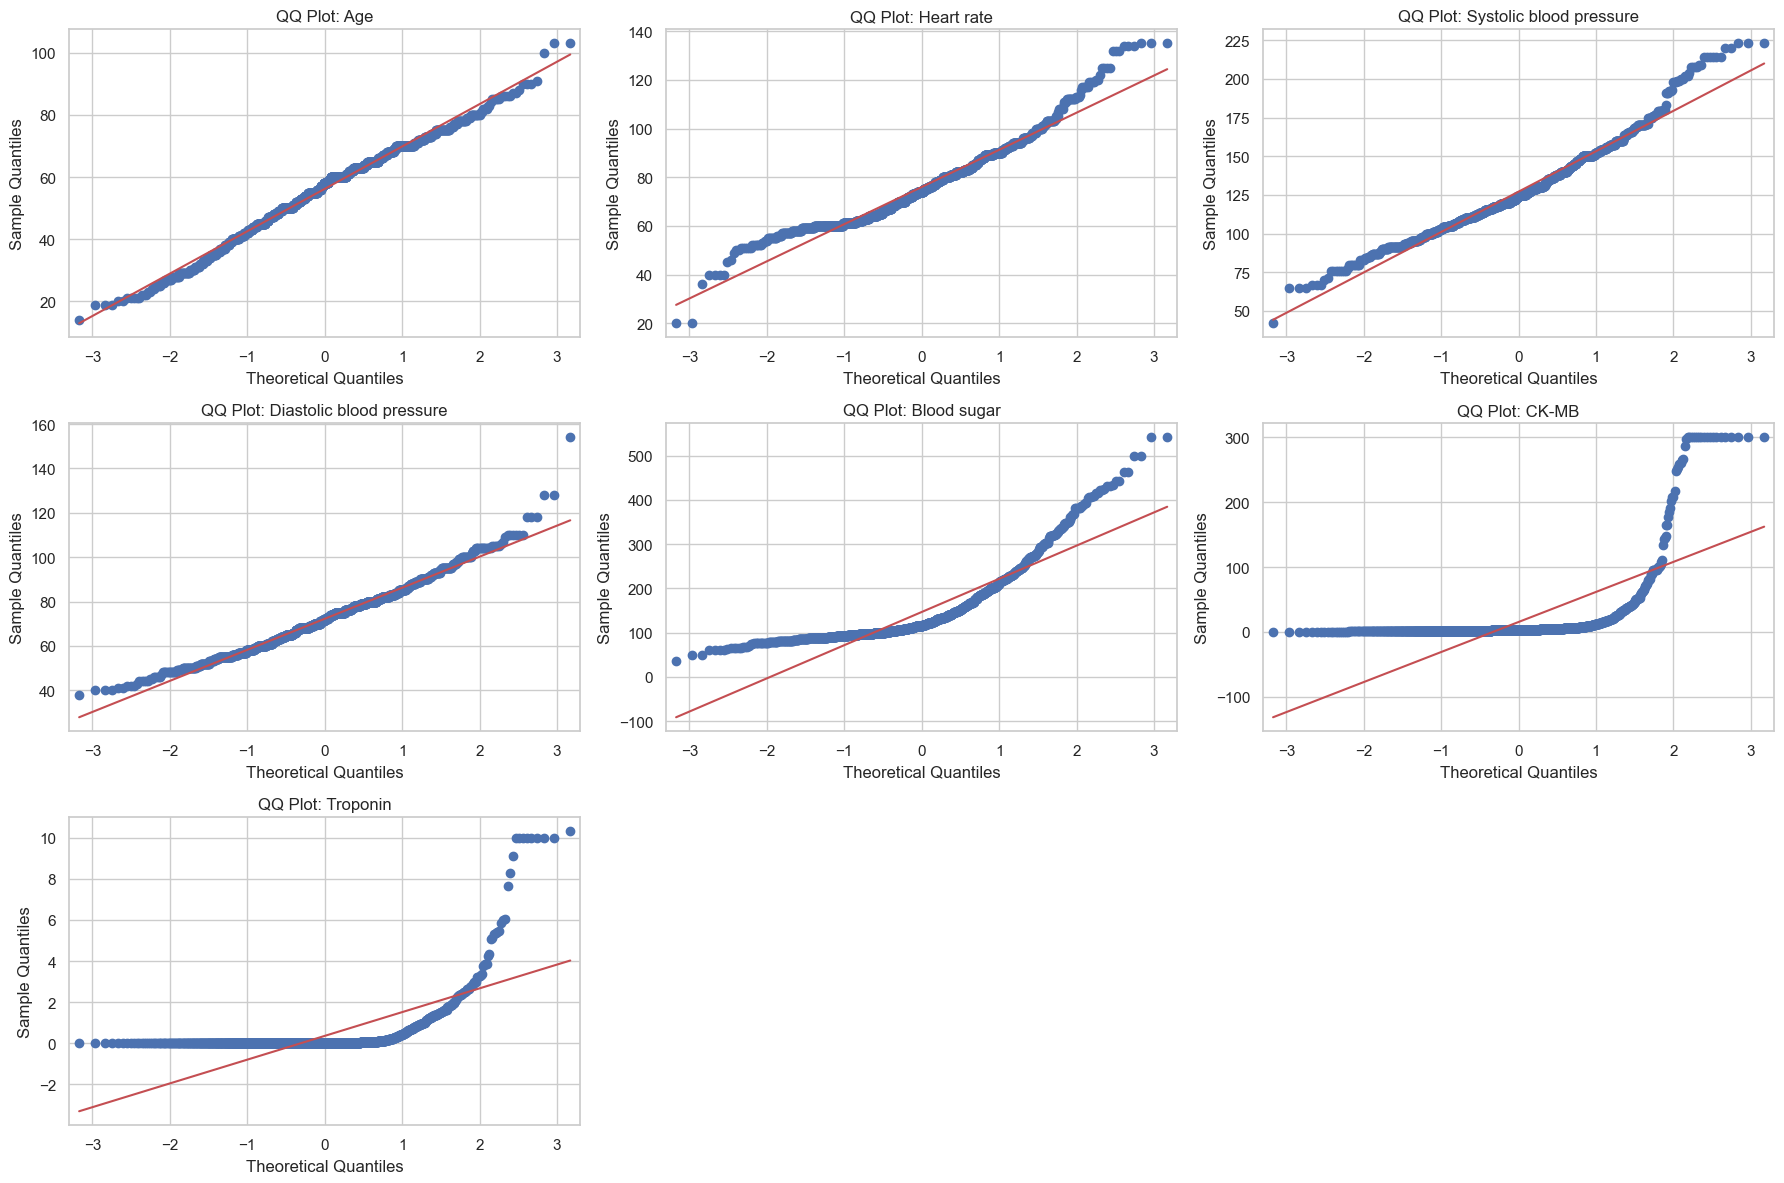

In [559]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot QQ plots
for i, var in enumerate(numeric_vars):
    sm.qqplot(df[var].dropna(), line='s', ax=axes[i])
    axes[i].set_title(f'QQ Plot: {var}')

# Remove any unused subplots
for j in range(len(numeric_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("qqplots_all_variables.png")

## Naradaya-Watson and kNN Regression for non-parametric regression analysis ##

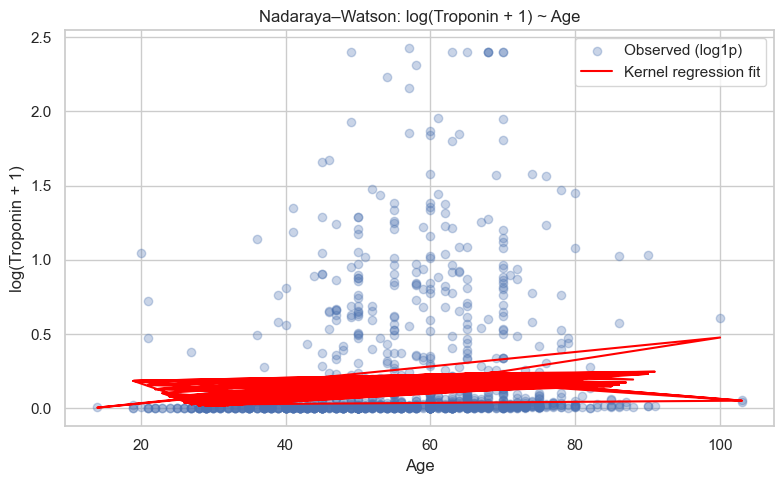

In [561]:
# We use log transformation for Troponin, in order to decrease the impact of numerous extreme outliers on the relationship between variables

data = df[['Age', 'Troponin']]
x = data['Age'].values
y = np.log1p(data['Troponin'].values)  # log(1 + Troponin)

# Kernel regression
model = KernelReg(endog=y, exog=x, var_type='c')
y_pred, _ = model.fit(x)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.3, label='Observed (log1p)')
plt.plot(x, y_pred, color='red', label='Kernel regression fit')
plt.title('Nadaraya–Watson: log(Troponin + 1) ~ Age')
plt.xlabel('Age')
plt.ylabel('log(Troponin + 1)')
plt.legend()
plt.tight_layout()
plt.savefig("nw_log_troponin_age.png")
plt.show()

To explore the relationship between Age and Troponin, a nonparametric Nadaraya–Watson kernel regression was applied using a log-transformed response variable (log(Troponin + 1)) to correct for skewness. The resulting curve revealed a moderate increasing trend, indicating that Troponin levels tend to rise with age. This nonparametric approach provided a smooth, data-driven estimate of the underlying relationship without relying on linearity assumptions, making it well-suited to the structure of the clinical dataset.

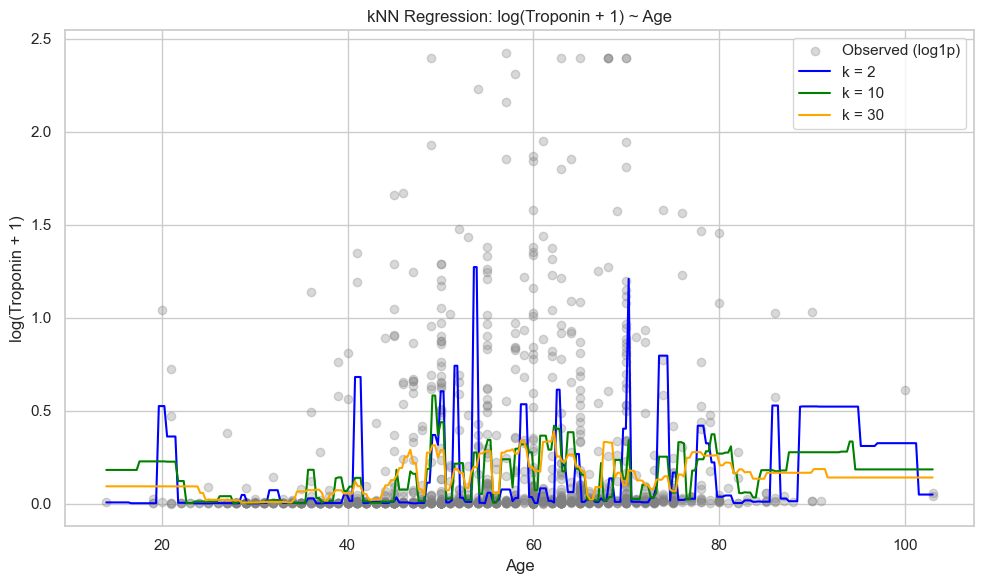

In [563]:
# Prepare data
x = data['Age'].values.reshape(-1, 1)
y = np.log1p(data['Troponin'].values)

# Define grid for smooth x-axis
x_plot = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)

# Different k values to compare
k_values = [2, 10, 30]
colors = ['blue', 'green', 'orange']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.3, label='Observed (log1p)', color='gray')

# Plot kNN regression fits
for k, color in zip(k_values, colors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x, y)
    y_pred = knn.predict(x_plot)
    plt.plot(x_plot, y_pred, label=f'k = {k}', color=color)

plt.title('kNN Regression: log(Troponin + 1) ~ Age')
plt.xlabel('Age')
plt.ylabel('log(Troponin + 1)')
plt.legend()
plt.tight_layout()
#plt.savefig("knn_regression_troponin_age.png")
plt.show()

To further explore the relationship between Age and Troponin, nonparametric k-nearest neighbor (kNN) regression was applied for multiple values of k (e.g., 2, 10, 30). Lower values of k produced highly flexible but noisy fits, while higher values led to smoother curves. The results illustrate the bias–variance tradeoff in nonparametric methods, with moderate k offering the most stable estimation of the underlying pattern.

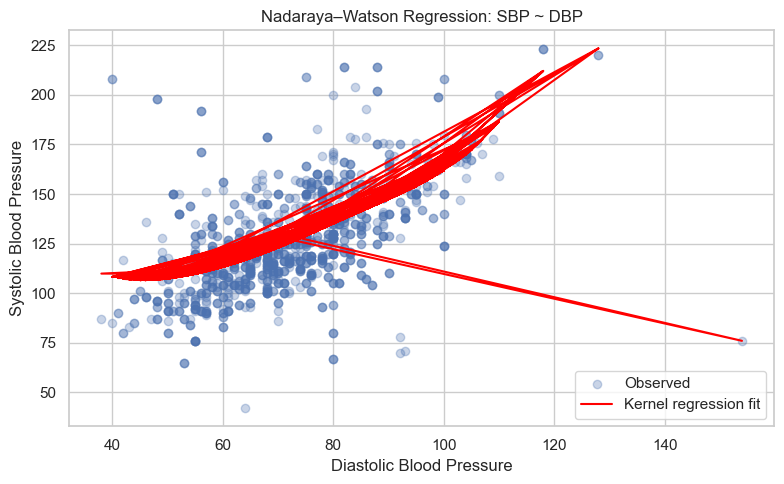

In [414]:
# Drop missing values
data = df[['Diastolic blood pressure', 'Systolic blood pressure']]
x = data['Diastolic blood pressure'].values
y = data['Systolic blood pressure'].values

# Fit kernel regression model
model = KernelReg(endog=y, exog=x, var_type='c')
y_pred, _ = model.fit(x)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.3, label='Observed')
plt.plot(x, y_pred, color='red', label='Kernel regression fit')
plt.title('Nadaraya–Watson Regression: SBP ~ DBP')
plt.xlabel('Diastolic Blood Pressure')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.tight_layout()
plt.savefig("nw_sbp_dbp.png")
plt.show()

A nonparametric regression was conducted to model Systolic Blood Pressure as a function of Diastolic Blood Pressure using the Nadaraya–Watson kernel estimator. The resulting curve revealed a strong, nearly linear relationship with minor nonlinear deviations, consistent with the physiological connection between the two variables. This analysis confirmed the monotonic association observed in earlier correlation results.

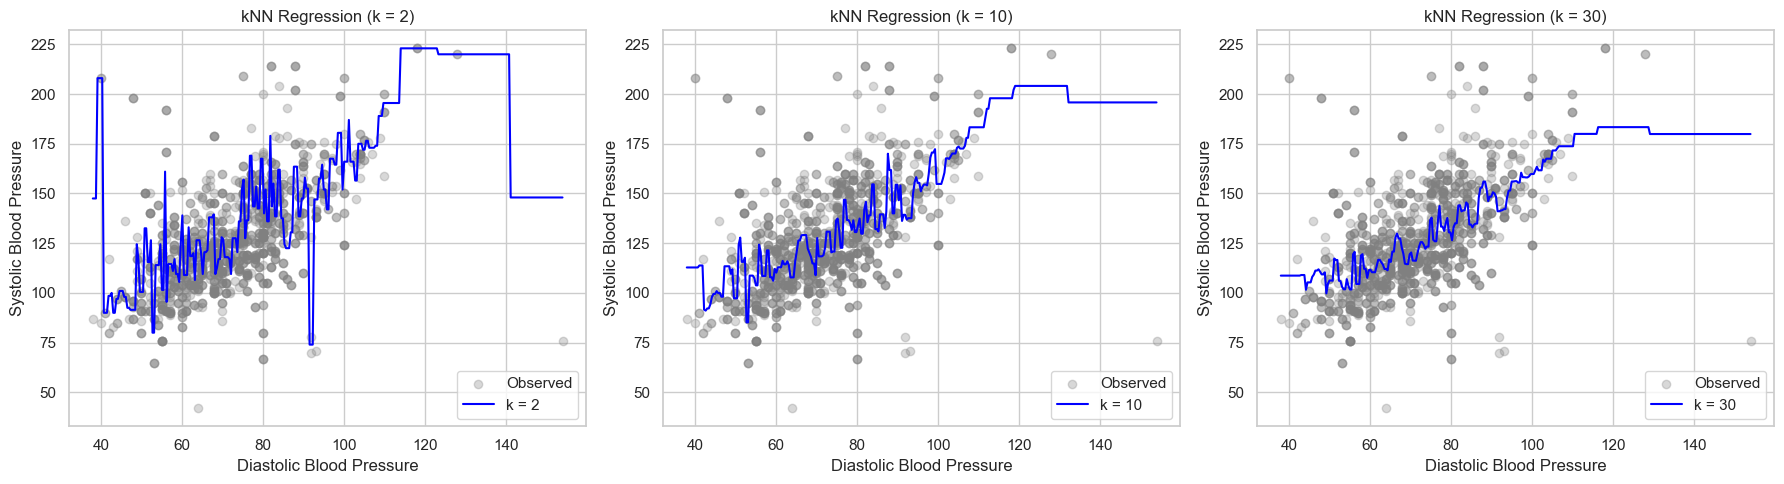

In [576]:
x = df['Diastolic blood pressure'].values.reshape(-1, 1)
y = df['Systolic blood pressure'].values

x_plot = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)

k_values = [2, 10, 30]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, k in zip(axes, k_values):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x, y)
    y_pred = knn.predict(x_plot)

    ax.scatter(x, y, color='gray', alpha=0.3, label='Observed')
    ax.plot(x_plot, y_pred, label=f'k = {k}', color='blue')
    ax.set_title(f'kNN Regression (k = {k})')
    ax.set_xlabel('Diastolic Blood Pressure')
    ax.set_ylabel('Systolic Blood Pressure')
    ax.legend()

plt.tight_layout()
plt.savefig("knn_regression_sbp_dbp_subplots.png")

A nonparametric regression analysis was performed to model Systolic Blood Pressure as a function of Diastolic Blood Pressure using k-Nearest Neighbors (kNN) regression. Models were fit for k = 2, 10, and 30. The k = 2 model overfit the data and captured local noise, while k = 30 was overly smoothed. The k = 10 model provided the best trade-off, revealing a clear monotonic relationship that supports physiological expectations. This further confirms the strength and nonlinearity of the association between DBP and SBP.

## kNN for binary classification of Result (Negative/Positive) ##

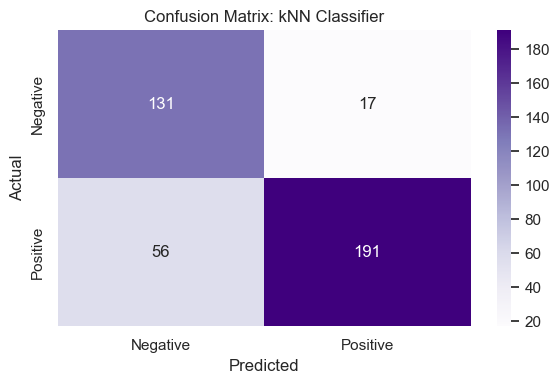

In [592]:
X = df[['Age', 'Troponin', 'CK-MB']]  # Using only significant features given the result of analysis 
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit scaler only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Evaluate performance
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: kNN Classifier")
plt.tight_layout()
plt.savefig('conf_matrix.png')
plt.show()

In [590]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       148
           1       0.92      0.77      0.84       247

    accuracy                           0.82       395
   macro avg       0.81      0.83      0.81       395
weighted avg       0.84      0.82      0.82       395

